In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import QuantileTransformer
scaler = QuantileTransformer(output_distribution='uniform')

In [2]:
DATASET_DIRECTORY = '/kaggle/input/unb-cic-iot-dataset/wataiData/csv/CICIoT2023/'

In [3]:
df_sets = [k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('.csv')]
df_sets.sort()
training_sets = df_sets[:int(len(df_sets)*.67)]
test_sets = df_sets[int(len(df_sets)*.67):]

In [4]:
X_columns = [
    'flow_duration', 'Header_Length', 'Protocol Type', 'Duration',
    'Rate', 'Srate', 'Drate', 'fin_flag_number', 'syn_flag_number',
    'rst_flag_number', 'psh_flag_number', 'ack_flag_number',
    'ece_flag_number', 'cwr_flag_number', 'ack_count',
    'syn_count', 'fin_count', 'urg_count', 'rst_count', 
    'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP',
    'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC', 'Tot sum', 'Min',
    'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Magnitue',
    'Radius', 'Covariance', 'Variance', 'Weight', 
]
y_column = 'label'

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
def build_CNN_model(input_shape):
    model = Sequential([
        Conv1D(32, 3, activation='relu', input_shape=input_shape),
        MaxPooling1D(2),
        Conv1D(64, 3, activation='relu'),
        MaxPooling1D(2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(34, activation='softmax')  # Output layer with softmax activation for multiclass
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

2024-03-19 12:43:19.397495: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-19 12:43:19.397597: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-19 12:43:19.747406: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
DL_models = [
        build_CNN_model(input_shape=(len(X_columns),1))
            ]

In [7]:
DL_names = [
        "CNN",
]

In [8]:
dict_2classes = {}
dict_2classes['DDoS-RSTFINFlood'] = 'Attack'
dict_2classes['DDoS-PSHACK_Flood'] = 'Attack'
dict_2classes['DDoS-SYN_Flood'] = 'Attack'
dict_2classes['DDoS-UDP_Flood'] = 'Attack'
dict_2classes['DDoS-TCP_Flood'] = 'Attack'
dict_2classes['DDoS-ICMP_Flood'] = 'Attack'
dict_2classes['DDoS-SynonymousIP_Flood'] = 'Attack'
dict_2classes['DDoS-ACK_Fragmentation'] = 'Attack'
dict_2classes['DDoS-UDP_Fragmentation'] = 'Attack'
dict_2classes['DDoS-ICMP_Fragmentation'] = 'Attack'
dict_2classes['DDoS-SlowLoris'] = 'Attack'
dict_2classes['DDoS-HTTP_Flood'] = 'Attack'

dict_2classes['DoS-UDP_Flood'] = 'Attack'
dict_2classes['DoS-SYN_Flood'] = 'Attack'
dict_2classes['DoS-TCP_Flood'] = 'Attack'
dict_2classes['DoS-HTTP_Flood'] = 'Attack'


dict_2classes['Mirai-greeth_flood'] = 'Attack'
dict_2classes['Mirai-greip_flood'] = 'Attack'
dict_2classes['Mirai-udpplain'] = 'Attack'
dict_2classes['Recon-PingSweep'] = 'Attack'
dict_2classes['Recon-OSScan'] = 'Attack'
dict_2classes['Recon-PortScan'] = 'Attack'
dict_2classes['VulnerabilityScan'] = 'Attack'
dict_2classes['Recon-HostDiscovery'] = 'Attack'

dict_2classes['DNS_Spoofing'] = 'Attack'
dict_2classes['MITM-ArpSpoofing'] = 'Attack'

dict_2classes['BenignTraffic'] = 'Benign'

dict_2classes['BrowserHijacking'] = 'Attack'
dict_2classes['Backdoor_Malware'] = 'Attack'
dict_2classes['XSS'] = 'Attack'
dict_2classes['Uploading_Attack'] = 'Attack'
dict_2classes['SqlInjection'] = 'Attack'
dict_2classes['CommandInjection'] = 'Attack'

dict_2classes['DictionaryBruteForce'] = 'Attack'

In [9]:
for train_set in tqdm(training_sets):
        d = pd.read_csv(DATASET_DIRECTORY + train_set)
        d[X_columns] = scaler.fit_transform(d[X_columns])
        new_y = [dict_2classes[k] for k in d[y_column]]
        d[y_column] = new_y
        X_train = d[X_columns].values
        y_train = d[y_column].values
        from sklearn.preprocessing import LabelEncoder

        label_encoder = LabelEncoder()
        y_train_encoded = label_encoder.fit_transform(y_train)
        for model in (DL_models):
            model.fit(X_train, y_train_encoded, epochs=3, batch_size=40, validation_split=0.3)
        del d

  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 1/3
  80/4177 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8636 - loss: 1.3453

I0000 00:00:1710852227.336157      73 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1710852227.355832      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4164/4177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9787 - loss: 0.1061

W0000 00:00:1710852235.947573      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4177/4177 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.9787 - loss: 0.1059 - val_accuracy: 0.9885 - val_loss: 0.0238
Epoch 2/3
4177/4177 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9886 - loss: 0.0245 - val_accuracy: 0.9894 - val_loss: 0.0224
Epoch 3/3
4177/4177 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9892 - loss: 0.0226 - val_accuracy: 0.9905 - val_loss: 0.0209


  1%|          | 1/113 [00:43<1:21:48, 43.82s/it]

Epoch 1/3
  80/3830 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9844 - loss: 0.0356

W0000 00:00:1710852266.538571      74 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3830/3830 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9899 - loss: 0.0218

W0000 00:00:1710852276.549874      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3830/3830 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.9899 - loss: 0.0218 - val_accuracy: 0.9898 - val_loss: 0.0214
Epoch 2/3
3830/3830 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9907 - loss: 0.0208 - val_accuracy: 0.9906 - val_loss: 0.0214
Epoch 3/3
3830/3830 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9907 - loss: 0.0207 - val_accuracy: 0.9896 - val_loss: 0.0213


  2%|▏         | 2/113 [01:22<1:15:14, 40.67s/it]

Epoch 1/3
4817/4817 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9905 - loss: 0.0207 - val_accuracy: 0.9910 - val_loss: 0.0192
Epoch 2/3
4817/4817 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9909 - loss: 0.0199 - val_accuracy: 0.9904 - val_loss: 0.0205
Epoch 3/3
4817/4817 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9910 - loss: 0.0195 - val_accuracy: 0.9914 - val_loss: 0.0183


  3%|▎         | 3/113 [02:04<1:15:51, 41.38s/it]

Epoch 1/3
4043/4043 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9914 - loss: 0.0189

W0000 00:00:1710852355.404436      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4043/4043 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9914 - loss: 0.0189 - val_accuracy: 0.9914 - val_loss: 0.0182
Epoch 2/3
  80/4043 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9937 - loss: 0.0167

W0000 00:00:1710852358.493760      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4043/4043 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9912 - loss: 0.0192 - val_accuracy: 0.9919 - val_loss: 0.0174
Epoch 3/3
4043/4043 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9908 - loss: 0.0195 - val_accuracy: 0.9918 - val_loss: 0.0176


  4%|▎         | 4/113 [02:42<1:12:37, 39.98s/it]

Epoch 1/3
3982/3982 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9915 - loss: 0.0191 - val_accuracy: 0.9927 - val_loss: 0.0165
Epoch 2/3
  83/3982 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9917 - loss: 0.0141

W0000 00:00:1710852393.151428      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3982/3982 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9915 - loss: 0.0184 - val_accuracy: 0.9927 - val_loss: 0.0169
Epoch 3/3
3982/3982 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9914 - loss: 0.0191 - val_accuracy: 0.9925 - val_loss: 0.0168


  4%|▍         | 5/113 [03:16<1:08:15, 37.92s/it]

Epoch 1/3
4201/4201 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9906 - loss: 0.0198

W0000 00:00:1710852427.751010      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4201/4201 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9906 - loss: 0.0198 - val_accuracy: 0.9926 - val_loss: 0.0176
Epoch 2/3
4201/4201 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9912 - loss: 0.0187 - val_accuracy: 0.9921 - val_loss: 0.0176
Epoch 3/3
4201/4201 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9915 - loss: 0.0187 - val_accuracy: 0.9916 - val_loss: 0.0184


  5%|▌         | 6/113 [03:55<1:08:11, 38.24s/it]

Epoch 1/3
4092/4092 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9914 - loss: 0.0186

W0000 00:00:1710852466.812857      75 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4092/4092 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9914 - loss: 0.0186 - val_accuracy: 0.9921 - val_loss: 0.0169
Epoch 2/3
4092/4092 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9920 - loss: 0.0179 - val_accuracy: 0.9918 - val_loss: 0.0174
Epoch 3/3
4092/4092 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9916 - loss: 0.0190 - val_accuracy: 0.9919 - val_loss: 0.0175


  6%|▌         | 7/113 [04:33<1:07:11, 38.03s/it]

Epoch 1/3
3989/3989 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9917 - loss: 0.0186 - val_accuracy: 0.9922 - val_loss: 0.0175
Epoch 2/3
  78/3989 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9896 - loss: 0.0183

W0000 00:00:1710852507.195709      75 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3989/3989 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9918 - loss: 0.0180 - val_accuracy: 0.9920 - val_loss: 0.0176
Epoch 3/3
3989/3989 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9914 - loss: 0.0179 - val_accuracy: 0.9919 - val_loss: 0.0177


  7%|▋         | 8/113 [05:11<1:06:38, 38.08s/it]

Epoch 1/3
4311/4311 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.9921 - loss: 0.0175 - val_accuracy: 0.9923 - val_loss: 0.0171
Epoch 2/3
  86/4311 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9944 - loss: 0.0158

W0000 00:00:1710852546.945433      75 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4311/4311 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9920 - loss: 0.0176 - val_accuracy: 0.9924 - val_loss: 0.0170
Epoch 3/3
4311/4311 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9923 - loss: 0.0173 - val_accuracy: 0.9923 - val_loss: 0.0168


  8%|▊         | 9/113 [05:52<1:07:29, 38.94s/it]

Epoch 1/3
3984/3984 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9918 - loss: 0.0184

W0000 00:00:1710852582.719625      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3984/3984 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9918 - loss: 0.0184 - val_accuracy: 0.9919 - val_loss: 0.0174
Epoch 2/3
3984/3984 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9921 - loss: 0.0178 - val_accuracy: 0.9919 - val_loss: 0.0177
Epoch 3/3
3984/3984 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9926 - loss: 0.0171 - val_accuracy: 0.9922 - val_loss: 0.0169


  9%|▉         | 10/113 [06:29<1:06:10, 38.55s/it]

Epoch 1/3
4400/4400 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9917 - loss: 0.0185 - val_accuracy: 0.9912 - val_loss: 0.0181
Epoch 2/3
4400/4400 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9922 - loss: 0.0177 - val_accuracy: 0.9915 - val_loss: 0.0181
Epoch 3/3
4400/4400 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9926 - loss: 0.0171 - val_accuracy: 0.9917 - val_loss: 0.0177


 10%|▉         | 11/113 [07:10<1:06:27, 39.09s/it]

Epoch 1/3
3884/3884 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9918 - loss: 0.0185 - val_accuracy: 0.9924 - val_loss: 0.0172
Epoch 2/3
3884/3884 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9920 - loss: 0.0177 - val_accuracy: 0.9926 - val_loss: 0.0174
Epoch 3/3
3884/3884 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9919 - loss: 0.0177 - val_accuracy: 0.9920 - val_loss: 0.0189


 11%|█         | 12/113 [07:47<1:04:42, 38.45s/it]

Epoch 1/3
4174/4174 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9920 - loss: 0.0180

W0000 00:00:1710852698.206859      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4174/4174 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9920 - loss: 0.0180 - val_accuracy: 0.9922 - val_loss: 0.0182
Epoch 2/3
4174/4174 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9920 - loss: 0.0173 - val_accuracy: 0.9923 - val_loss: 0.0174
Epoch 3/3
4174/4174 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9917 - loss: 0.0174 - val_accuracy: 0.9920 - val_loss: 0.0175


 12%|█▏        | 13/113 [08:25<1:04:13, 38.53s/it]

Epoch 1/3
4179/4179 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9919 - loss: 0.0180 - val_accuracy: 0.9915 - val_loss: 0.0177
Epoch 2/3
4179/4179 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9925 - loss: 0.0173 - val_accuracy: 0.9919 - val_loss: 0.0179
Epoch 3/3
4179/4179 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9923 - loss: 0.0173 - val_accuracy: 0.9914 - val_loss: 0.0185


 12%|█▏        | 14/113 [09:04<1:03:35, 38.54s/it]

Epoch 1/3
3778/3778 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9920 - loss: 0.0177 - val_accuracy: 0.9914 - val_loss: 0.0188
Epoch 2/3
  79/3778 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9906 - loss: 0.0176

W0000 00:00:1710852776.881409      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3778/3778 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9922 - loss: 0.0169 - val_accuracy: 0.9920 - val_loss: 0.0190
Epoch 3/3
3778/3778 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9922 - loss: 0.0172 - val_accuracy: 0.9917 - val_loss: 0.0188


 13%|█▎        | 15/113 [09:39<1:01:02, 37.38s/it]

Epoch 1/3
4702/4702 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9915 - loss: 0.0183 - val_accuracy: 0.9923 - val_loss: 0.0166
Epoch 2/3
  79/4702 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9961 - loss: 0.0108

W0000 00:00:1710852812.885995      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4702/4702 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9917 - loss: 0.0180 - val_accuracy: 0.9925 - val_loss: 0.0166
Epoch 3/3
4702/4702 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9916 - loss: 0.0185 - val_accuracy: 0.9924 - val_loss: 0.0171


 14%|█▍        | 16/113 [10:20<1:02:23, 38.59s/it]

Epoch 1/3
4076/4076 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9921 - loss: 0.0180

W0000 00:00:1710852851.714967      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4076/4076 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9921 - loss: 0.0180 - val_accuracy: 0.9923 - val_loss: 0.0172
Epoch 2/3
4076/4076 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9914 - loss: 0.0182 - val_accuracy: 0.9923 - val_loss: 0.0173
Epoch 3/3
4076/4076 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9921 - loss: 0.0170 - val_accuracy: 0.9922 - val_loss: 0.0173


 15%|█▌        | 17/113 [10:58<1:01:38, 38.53s/it]

Epoch 1/3
3911/3911 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9921 - loss: 0.0175 - val_accuracy: 0.9921 - val_loss: 0.0168
Epoch 2/3
3911/3911 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9923 - loss: 0.0170 - val_accuracy: 0.9920 - val_loss: 0.0169
Epoch 3/3
3911/3911 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9921 - loss: 0.0172 - val_accuracy: 0.9916 - val_loss: 0.0171


 16%|█▌        | 18/113 [11:35<1:00:05, 37.95s/it]

Epoch 1/3
4103/4103 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9919 - loss: 0.0174 - val_accuracy: 0.9924 - val_loss: 0.0171
Epoch 2/3
4103/4103 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.9919 - loss: 0.0176 - val_accuracy: 0.9925 - val_loss: 0.0168
Epoch 3/3
4103/4103 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9923 - loss: 0.0170 - val_accuracy: 0.9920 - val_loss: 0.0171


 17%|█▋        | 19/113 [12:20<1:02:35, 39.95s/it]

Epoch 1/3
4044/4044 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.9925 - loss: 0.0171 - val_accuracy: 0.9921 - val_loss: 0.0165
Epoch 2/3
  81/4044 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9922 - loss: 0.0176

W0000 00:00:1710852974.989202      75 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4044/4044 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9918 - loss: 0.0182 - val_accuracy: 0.9923 - val_loss: 0.0167
Epoch 3/3
4044/4044 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9922 - loss: 0.0174 - val_accuracy: 0.9921 - val_loss: 0.0169


 18%|█▊        | 20/113 [12:59<1:01:30, 39.68s/it]

Epoch 1/3
4151/4151 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9922 - loss: 0.0170 - val_accuracy: 0.9926 - val_loss: 0.0168
Epoch 2/3
4151/4151 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9927 - loss: 0.0167 - val_accuracy: 0.9919 - val_loss: 0.0184
Epoch 3/3
4151/4151 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9927 - loss: 0.0168 - val_accuracy: 0.9924 - val_loss: 0.0177


 19%|█▊        | 21/113 [13:36<59:54, 39.08s/it]  

Epoch 1/3
3910/3910 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9922 - loss: 0.0170 - val_accuracy: 0.9926 - val_loss: 0.0168
Epoch 2/3
3910/3910 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9923 - loss: 0.0167 - val_accuracy: 0.9925 - val_loss: 0.0181
Epoch 3/3
3910/3910 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9932 - loss: 0.0158 - val_accuracy: 0.9926 - val_loss: 0.0172


 19%|█▉        | 22/113 [14:13<58:17, 38.44s/it]

Epoch 1/3
4414/4414 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9917 - loss: 0.0184 - val_accuracy: 0.9923 - val_loss: 0.0167
Epoch 2/3
4414/4414 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9921 - loss: 0.0173 - val_accuracy: 0.9925 - val_loss: 0.0167
Epoch 3/3
4414/4414 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9921 - loss: 0.0177 - val_accuracy: 0.9927 - val_loss: 0.0165


 20%|██        | 23/113 [14:51<57:34, 38.39s/it]

Epoch 1/3
4587/4587 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9926 - loss: 0.0167 - val_accuracy: 0.9920 - val_loss: 0.0175
Epoch 2/3
4587/4587 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9923 - loss: 0.0171 - val_accuracy: 0.9922 - val_loss: 0.0167
Epoch 3/3
4587/4587 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9923 - loss: 0.0178 - val_accuracy: 0.9923 - val_loss: 0.0172


 21%|██        | 24/113 [15:31<57:22, 38.68s/it]

Epoch 1/3
3951/3951 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9918 - loss: 0.0176 - val_accuracy: 0.9921 - val_loss: 0.0179
Epoch 2/3
  82/3951 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9880 - loss: 0.0234

W0000 00:00:1710853164.898726      75 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3951/3951 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9922 - loss: 0.0172 - val_accuracy: 0.9922 - val_loss: 0.0163
Epoch 3/3
3951/3951 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9921 - loss: 0.0169 - val_accuracy: 0.9923 - val_loss: 0.0167


 22%|██▏       | 25/113 [16:08<55:54, 38.12s/it]

Epoch 1/3
7834/7834 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9920 - loss: 0.0178 - val_accuracy: 0.9923 - val_loss: 0.0168
Epoch 2/3
7834/7834 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9921 - loss: 0.0175 - val_accuracy: 0.9922 - val_loss: 0.0168
Epoch 3/3
7834/7834 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9923 - loss: 0.0168 - val_accuracy: 0.9924 - val_loss: 0.0162


 23%|██▎       | 26/113 [17:14<1:07:41, 46.68s/it]

Epoch 1/3
4133/4133 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9921 - loss: 0.0173 - val_accuracy: 0.9923 - val_loss: 0.0163
Epoch 2/3
4133/4133 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9924 - loss: 0.0170 - val_accuracy: 0.9922 - val_loss: 0.0173
Epoch 3/3
4133/4133 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9921 - loss: 0.0173 - val_accuracy: 0.9920 - val_loss: 0.0175


 24%|██▍       | 27/113 [17:53<1:03:37, 44.39s/it]

Epoch 1/3
3868/3868 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9921 - loss: 0.0176 - val_accuracy: 0.9928 - val_loss: 0.0161
Epoch 2/3
3868/3868 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9916 - loss: 0.0181 - val_accuracy: 0.9928 - val_loss: 0.0158
Epoch 3/3
3868/3868 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9926 - loss: 0.0173 - val_accuracy: 0.9929 - val_loss: 0.0161


 25%|██▍       | 28/113 [18:27<58:28, 41.28s/it]  

Epoch 1/3
4397/4397 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9922 - loss: 0.0177 - val_accuracy: 0.9923 - val_loss: 0.0178
Epoch 2/3
4397/4397 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9925 - loss: 0.0166 - val_accuracy: 0.9927 - val_loss: 0.0176
Epoch 3/3
4397/4397 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9924 - loss: 0.0166 - val_accuracy: 0.9927 - val_loss: 0.0174


 26%|██▌       | 29/113 [19:05<56:17, 40.21s/it]

Epoch 1/3
4405/4405 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9924 - loss: 0.0173 - val_accuracy: 0.9924 - val_loss: 0.0167
Epoch 2/3
4405/4405 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9924 - loss: 0.0166 - val_accuracy: 0.9922 - val_loss: 0.0164
Epoch 3/3
4405/4405 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9926 - loss: 0.0168 - val_accuracy: 0.9922 - val_loss: 0.0166


 27%|██▋       | 30/113 [19:52<58:22, 42.20s/it]

Epoch 1/3
4172/4172 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9921 - loss: 0.0178 - val_accuracy: 0.9924 - val_loss: 0.0169
Epoch 2/3
4172/4172 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9920 - loss: 0.0178 - val_accuracy: 0.9926 - val_loss: 0.0168
Epoch 3/3
4172/4172 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9921 - loss: 0.0174 - val_accuracy: 0.9922 - val_loss: 0.0172


 27%|██▋       | 31/113 [20:28<55:18, 40.47s/it]

Epoch 1/3
4003/4003 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9921 - loss: 0.0176 - val_accuracy: 0.9929 - val_loss: 0.0161
Epoch 2/3
4003/4003 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9925 - loss: 0.0166 - val_accuracy: 0.9931 - val_loss: 0.0162
Epoch 3/3
4003/4003 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9925 - loss: 0.0168 - val_accuracy: 0.9924 - val_loss: 0.0171


 28%|██▊       | 32/113 [21:06<53:39, 39.74s/it]

Epoch 1/3
3984/3984 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9924 - loss: 0.0169 - val_accuracy: 0.9927 - val_loss: 0.0161
Epoch 2/3
  80/3984 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9934 - loss: 0.0152

W0000 00:00:1710853501.461022      74 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3984/3984 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9925 - loss: 0.0169 - val_accuracy: 0.9922 - val_loss: 0.0187
Epoch 3/3
3984/3984 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9924 - loss: 0.0173 - val_accuracy: 0.9930 - val_loss: 0.0162


 29%|██▉       | 33/113 [21:45<52:20, 39.25s/it]

Epoch 1/3
7837/7837 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.9924 - loss: 0.0163 - val_accuracy: 0.9933 - val_loss: 0.0155
Epoch 2/3
7837/7837 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9927 - loss: 0.0165 - val_accuracy: 0.9932 - val_loss: 0.0160
Epoch 3/3
7837/7837 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.9929 - loss: 0.0161 - val_accuracy: 0.9931 - val_loss: 0.0156


 30%|███       | 34/113 [23:16<1:12:09, 54.80s/it]

Epoch 1/3
4064/4064 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9923 - loss: 0.0171

W0000 00:00:1710853627.043738      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4064/4064 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9923 - loss: 0.0171 - val_accuracy: 0.9921 - val_loss: 0.0174
Epoch 2/3
4064/4064 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.9923 - loss: 0.0169 - val_accuracy: 0.9922 - val_loss: 0.0172
Epoch 3/3
4064/4064 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9930 - loss: 0.0162 - val_accuracy: 0.9921 - val_loss: 0.0170


 31%|███       | 35/113 [24:11<1:11:20, 54.88s/it]

Epoch 1/3
4423/4423 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9921 - loss: 0.0174 - val_accuracy: 0.9928 - val_loss: 0.0159
Epoch 2/3
4423/4423 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9925 - loss: 0.0165 - val_accuracy: 0.9930 - val_loss: 0.0161
Epoch 3/3
4423/4423 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9923 - loss: 0.0168 - val_accuracy: 0.9928 - val_loss: 0.0157


 32%|███▏      | 36/113 [24:49<1:03:56, 49.83s/it]

Epoch 1/3
7687/7687 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9925 - loss: 0.0173

W0000 00:00:1710853730.428544      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


7687/7687 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.9925 - loss: 0.0173 - val_accuracy: 0.9925 - val_loss: 0.0165
Epoch 2/3
7687/7687 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.9928 - loss: 0.0166 - val_accuracy: 0.9925 - val_loss: 0.0173
Epoch 3/3
7687/7687 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9926 - loss: 0.0167 - val_accuracy: 0.9918 - val_loss: 0.0172


 33%|███▎      | 37/113 [25:59<1:11:04, 56.11s/it]

Epoch 1/3
3762/3762 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9921 - loss: 0.0176 - val_accuracy: 0.9924 - val_loss: 0.0163
Epoch 2/3
3762/3762 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9924 - loss: 0.0171 - val_accuracy: 0.9921 - val_loss: 0.0181
Epoch 3/3
3762/3762 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9924 - loss: 0.0163 - val_accuracy: 0.9922 - val_loss: 0.0172


 34%|███▎      | 38/113 [26:34<1:02:11, 49.75s/it]

Epoch 1/3
4142/4142 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9922 - loss: 0.0170 - val_accuracy: 0.9922 - val_loss: 0.0191
Epoch 2/3
4142/4142 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9929 - loss: 0.0161 - val_accuracy: 0.9923 - val_loss: 0.0185
Epoch 3/3
4142/4142 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9929 - loss: 0.0161 - val_accuracy: 0.9927 - val_loss: 0.0178


 35%|███▍      | 39/113 [27:14<57:26, 46.57s/it]  

Epoch 1/3
7654/7654 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.9921 - loss: 0.0174 - val_accuracy: 0.9928 - val_loss: 0.0168
Epoch 2/3
7654/7654 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9924 - loss: 0.0176 - val_accuracy: 0.9932 - val_loss: 0.0156
Epoch 3/3
7654/7654 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9925 - loss: 0.0172 - val_accuracy: 0.9930 - val_loss: 0.0163


 35%|███▌      | 40/113 [28:22<1:04:49, 53.28s/it]

Epoch 1/3
4032/4032 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9930 - loss: 0.0163 - val_accuracy: 0.9922 - val_loss: 0.0163
Epoch 2/3
  79/4032 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9941 - loss: 0.0162

W0000 00:00:1710853934.391543      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4032/4032 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9927 - loss: 0.0163 - val_accuracy: 0.9923 - val_loss: 0.0162
Epoch 3/3
4032/4032 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9928 - loss: 0.0160 - val_accuracy: 0.9923 - val_loss: 0.0161


 36%|███▋      | 41/113 [28:58<57:38, 48.04s/it]  

Epoch 1/3
7793/7793 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.9924 - loss: 0.0170 - val_accuracy: 0.9924 - val_loss: 0.0167
Epoch 2/3
7793/7793 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9927 - loss: 0.0168 - val_accuracy: 0.9927 - val_loss: 0.0162
Epoch 3/3
7793/7793 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9926 - loss: 0.0168 - val_accuracy: 0.9927 - val_loss: 0.0163


 37%|███▋      | 42/113 [30:08<1:04:41, 54.67s/it]

Epoch 1/3
3893/3893 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9928 - loss: 0.0168 - val_accuracy: 0.9928 - val_loss: 0.0169
Epoch 2/3
3893/3893 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9921 - loss: 0.0177 - val_accuracy: 0.9931 - val_loss: 0.0166
Epoch 3/3
3893/3893 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9926 - loss: 0.0168 - val_accuracy: 0.9931 - val_loss: 0.0173


 38%|███▊      | 43/113 [30:42<56:33, 48.47s/it]  

Epoch 1/3
4392/4392 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9922 - loss: 0.0178

W0000 00:00:1710854075.726353      75 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4392/4392 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.9922 - loss: 0.0178 - val_accuracy: 0.9928 - val_loss: 0.0160
Epoch 2/3
4392/4392 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9926 - loss: 0.0162 - val_accuracy: 0.9927 - val_loss: 0.0169
Epoch 3/3
4392/4392 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9925 - loss: 0.0169 - val_accuracy: 0.9930 - val_loss: 0.0157


 39%|███▉      | 44/113 [31:26<54:06, 47.06s/it]

Epoch 1/3
4060/4060 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9924 - loss: 0.0167 - val_accuracy: 0.9924 - val_loss: 0.0162
Epoch 2/3
4060/4060 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9924 - loss: 0.0169 - val_accuracy: 0.9927 - val_loss: 0.0160
Epoch 3/3
4060/4060 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9924 - loss: 0.0167 - val_accuracy: 0.9925 - val_loss: 0.0163


 40%|███▉      | 45/113 [32:01<49:19, 43.53s/it]

Epoch 1/3
4328/4328 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.9929 - loss: 0.0167 - val_accuracy: 0.9926 - val_loss: 0.0165
Epoch 2/3
4328/4328 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9927 - loss: 0.0162 - val_accuracy: 0.9936 - val_loss: 0.0152
Epoch 3/3
4328/4328 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9931 - loss: 0.0165 - val_accuracy: 0.9930 - val_loss: 0.0158


 41%|████      | 46/113 [32:42<47:39, 42.68s/it]

Epoch 1/3
4123/4123 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9923 - loss: 0.0172 - val_accuracy: 0.9925 - val_loss: 0.0160
Epoch 2/3
4123/4123 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9924 - loss: 0.0167 - val_accuracy: 0.9924 - val_loss: 0.0164
Epoch 3/3
4123/4123 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9928 - loss: 0.0163 - val_accuracy: 0.9925 - val_loss: 0.0162


 42%|████▏     | 47/113 [33:18<44:42, 40.64s/it]

Epoch 1/3
4184/4184 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9928 - loss: 0.0170 - val_accuracy: 0.9926 - val_loss: 0.0162
Epoch 2/3
4184/4184 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9927 - loss: 0.0170 - val_accuracy: 0.9932 - val_loss: 0.0154
Epoch 3/3
4184/4184 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9927 - loss: 0.0169 - val_accuracy: 0.9925 - val_loss: 0.0164


 42%|████▏     | 48/113 [33:54<42:30, 39.23s/it]

Epoch 1/3
3848/3848 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9930 - loss: 0.0160 - val_accuracy: 0.9933 - val_loss: 0.0160
Epoch 2/3
3848/3848 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9927 - loss: 0.0165 - val_accuracy: 0.9934 - val_loss: 0.0156
Epoch 3/3
3848/3848 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9925 - loss: 0.0166 - val_accuracy: 0.9932 - val_loss: 0.0160


 43%|████▎     | 49/113 [34:27<39:56, 37.44s/it]

Epoch 1/3
4358/4358 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9928 - loss: 0.0166 - val_accuracy: 0.9928 - val_loss: 0.0165
Epoch 2/3
4358/4358 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9930 - loss: 0.0162 - val_accuracy: 0.9930 - val_loss: 0.0163
Epoch 3/3
4358/4358 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9927 - loss: 0.0160 - val_accuracy: 0.9933 - val_loss: 0.0151


 44%|████▍     | 50/113 [35:05<39:29, 37.61s/it]

Epoch 1/3
4089/4089 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9926 - loss: 0.0171 - val_accuracy: 0.9925 - val_loss: 0.0167
Epoch 2/3
4089/4089 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9928 - loss: 0.0164 - val_accuracy: 0.9931 - val_loss: 0.0152
Epoch 3/3
4089/4089 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9931 - loss: 0.0162 - val_accuracy: 0.9931 - val_loss: 0.0153


 45%|████▌     | 51/113 [35:41<38:10, 36.94s/it]

Epoch 1/3
4397/4397 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9921 - loss: 0.0175 - val_accuracy: 0.9930 - val_loss: 0.0164
Epoch 2/3
4397/4397 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9928 - loss: 0.0166 - val_accuracy: 0.9929 - val_loss: 0.0165
Epoch 3/3
4397/4397 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9923 - loss: 0.0169 - val_accuracy: 0.9926 - val_loss: 0.0172


 46%|████▌     | 52/113 [36:19<38:04, 37.45s/it]

Epoch 1/3
7795/7795 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.9924 - loss: 0.0171 - val_accuracy: 0.9926 - val_loss: 0.0166
Epoch 2/3
7795/7795 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9928 - loss: 0.0161 - val_accuracy: 0.9931 - val_loss: 0.0158
Epoch 3/3
7795/7795 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9932 - loss: 0.0156 - val_accuracy: 0.9925 - val_loss: 0.0170


 47%|████▋     | 53/113 [37:30<47:20, 47.34s/it]

Epoch 1/3
4258/4258 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9925 - loss: 0.0172 - val_accuracy: 0.9935 - val_loss: 0.0147
Epoch 2/3
4258/4258 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9924 - loss: 0.0171 - val_accuracy: 0.9928 - val_loss: 0.0158
Epoch 3/3
4258/4258 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9923 - loss: 0.0169 - val_accuracy: 0.9929 - val_loss: 0.0154


 48%|████▊     | 54/113 [38:06<43:20, 44.07s/it]

Epoch 1/3
4124/4124 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9923 - loss: 0.0170 - val_accuracy: 0.9930 - val_loss: 0.0157
Epoch 2/3
4124/4124 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9923 - loss: 0.0170 - val_accuracy: 0.9927 - val_loss: 0.0160
Epoch 3/3
4124/4124 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9920 - loss: 0.0169 - val_accuracy: 0.9933 - val_loss: 0.0157


 49%|████▊     | 55/113 [38:42<40:11, 41.58s/it]

Epoch 1/3
3892/3892 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9931 - loss: 0.0162 - val_accuracy: 0.9915 - val_loss: 0.0170
Epoch 2/3
  79/3892 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9947 - loss: 0.0107

W0000 00:00:1710854553.183061      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3892/3892 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9927 - loss: 0.0166 - val_accuracy: 0.9918 - val_loss: 0.0178
Epoch 3/3
3892/3892 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9932 - loss: 0.0159 - val_accuracy: 0.9925 - val_loss: 0.0164


 50%|████▉     | 56/113 [39:16<37:16, 39.24s/it]

Epoch 1/3
4113/4113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9926 - loss: 0.0166

W0000 00:00:1710854587.305643      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4113/4113 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9926 - loss: 0.0166 - val_accuracy: 0.9928 - val_loss: 0.0163
Epoch 2/3
4113/4113 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9931 - loss: 0.0158 - val_accuracy: 0.9928 - val_loss: 0.0165
Epoch 3/3
4113/4113 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9930 - loss: 0.0157 - val_accuracy: 0.9924 - val_loss: 0.0187


 50%|█████     | 57/113 [39:54<36:14, 38.83s/it]

Epoch 1/3
7518/7518 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9927 - loss: 0.0168 - val_accuracy: 0.9928 - val_loss: 0.0156
Epoch 2/3
7518/7518 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9927 - loss: 0.0168 - val_accuracy: 0.9931 - val_loss: 0.0152
Epoch 3/3
7518/7518 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9927 - loss: 0.0163 - val_accuracy: 0.9928 - val_loss: 0.0158


 51%|█████▏    | 58/113 [40:58<42:39, 46.54s/it]

Epoch 1/3
4148/4148 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9922 - loss: 0.0177 - val_accuracy: 0.9933 - val_loss: 0.0153
Epoch 2/3
4148/4148 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9927 - loss: 0.0165 - val_accuracy: 0.9932 - val_loss: 0.0150
Epoch 3/3
4148/4148 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.9924 - loss: 0.0173 - val_accuracy: 0.9933 - val_loss: 0.0148


 52%|█████▏    | 59/113 [41:45<41:54, 46.57s/it]

Epoch 1/3
4291/4291 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9927 - loss: 0.0164 - val_accuracy: 0.9930 - val_loss: 0.0160
Epoch 2/3
4291/4291 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9926 - loss: 0.0163 - val_accuracy: 0.9932 - val_loss: 0.0155
Epoch 3/3
4291/4291 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9927 - loss: 0.0165 - val_accuracy: 0.9924 - val_loss: 0.0172


 53%|█████▎    | 60/113 [42:31<41:01, 46.44s/it]

Epoch 1/3
4448/4448 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9930 - loss: 0.0166 - val_accuracy: 0.9930 - val_loss: 0.0154
Epoch 2/3
4448/4448 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9927 - loss: 0.0165 - val_accuracy: 0.9927 - val_loss: 0.0157
Epoch 3/3
4448/4448 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9928 - loss: 0.0159 - val_accuracy: 0.9922 - val_loss: 0.0172


 54%|█████▍    | 61/113 [43:09<38:11, 44.06s/it]

Epoch 1/3
4194/4194 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9927 - loss: 0.0168

W0000 00:00:1710854821.917760      74 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4194/4194 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9927 - loss: 0.0168 - val_accuracy: 0.9928 - val_loss: 0.0167
Epoch 2/3
4194/4194 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9929 - loss: 0.0163 - val_accuracy: 0.9925 - val_loss: 0.0169
Epoch 3/3
4194/4194 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9928 - loss: 0.0162 - val_accuracy: 0.9925 - val_loss: 0.0174


 55%|█████▍    | 62/113 [43:49<36:15, 42.66s/it]

Epoch 1/3
7718/7718 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9926 - loss: 0.0163 - val_accuracy: 0.9928 - val_loss: 0.0158
Epoch 2/3
7718/7718 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9929 - loss: 0.0159 - val_accuracy: 0.9925 - val_loss: 0.0165
Epoch 3/3
7718/7718 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9929 - loss: 0.0159 - val_accuracy: 0.9928 - val_loss: 0.0161


 56%|█████▌    | 63/113 [44:55<41:28, 49.77s/it]

Epoch 1/3
4155/4155 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9927 - loss: 0.0167 - val_accuracy: 0.9930 - val_loss: 0.0158
Epoch 2/3
4155/4155 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9926 - loss: 0.0168 - val_accuracy: 0.9933 - val_loss: 0.0149
Epoch 3/3
4155/4155 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9929 - loss: 0.0163 - val_accuracy: 0.9928 - val_loss: 0.0161


 57%|█████▋    | 64/113 [45:31<37:13, 45.58s/it]

Epoch 1/3
4604/4604 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9927 - loss: 0.0164 - val_accuracy: 0.9926 - val_loss: 0.0181
Epoch 2/3
4604/4604 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9931 - loss: 0.0157 - val_accuracy: 0.9933 - val_loss: 0.0152
Epoch 3/3
4604/4604 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9931 - loss: 0.0162 - val_accuracy: 0.9926 - val_loss: 0.0164


 58%|█████▊    | 65/113 [46:10<34:58, 43.72s/it]

Epoch 1/3
4287/4287 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9932 - loss: 0.0160 - val_accuracy: 0.9929 - val_loss: 0.0162
Epoch 2/3
4287/4287 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9929 - loss: 0.0163 - val_accuracy: 0.9928 - val_loss: 0.0154
Epoch 3/3
4287/4287 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9930 - loss: 0.0163 - val_accuracy: 0.9928 - val_loss: 0.0158


 58%|█████▊    | 66/113 [46:48<32:48, 41.89s/it]

Epoch 1/3
3782/3782 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9927 - loss: 0.0167 - val_accuracy: 0.9924 - val_loss: 0.0170
Epoch 2/3
3782/3782 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.9930 - loss: 0.0159 - val_accuracy: 0.9918 - val_loss: 0.0177
Epoch 3/3
3782/3782 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9925 - loss: 0.0164 - val_accuracy: 0.9923 - val_loss: 0.0166


 59%|█████▉    | 67/113 [47:31<32:29, 42.37s/it]

Epoch 1/3
4689/4689 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9919 - loss: 0.0173 - val_accuracy: 0.9931 - val_loss: 0.0158
Epoch 2/3
4689/4689 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9930 - loss: 0.0161 - val_accuracy: 0.9928 - val_loss: 0.0160
Epoch 3/3
4689/4689 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9922 - loss: 0.0172 - val_accuracy: 0.9931 - val_loss: 0.0155


 60%|██████    | 68/113 [48:12<31:17, 41.73s/it]

Epoch 1/3
3922/3922 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9927 - loss: 0.0165 - val_accuracy: 0.9933 - val_loss: 0.0155
Epoch 2/3
3922/3922 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9931 - loss: 0.0157 - val_accuracy: 0.9930 - val_loss: 0.0159
Epoch 3/3
3922/3922 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9928 - loss: 0.0166 - val_accuracy: 0.9927 - val_loss: 0.0157


 61%|██████    | 69/113 [48:46<28:55, 39.45s/it]

Epoch 1/3
4204/4204 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9928 - loss: 0.0163 - val_accuracy: 0.9927 - val_loss: 0.0163
Epoch 2/3
4204/4204 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9925 - loss: 0.0164 - val_accuracy: 0.9930 - val_loss: 0.0153
Epoch 3/3
4204/4204 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9925 - loss: 0.0165 - val_accuracy: 0.9936 - val_loss: 0.0149


 62%|██████▏   | 70/113 [49:23<27:43, 38.69s/it]

Epoch 1/3
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9925 - loss: 0.0168 - val_accuracy: 0.9928 - val_loss: 0.0166
Epoch 2/3
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9928 - loss: 0.0162 - val_accuracy: 0.9932 - val_loss: 0.0151
Epoch 3/3
4022/4022 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9922 - loss: 0.0170 - val_accuracy: 0.9935 - val_loss: 0.0151


 63%|██████▎   | 71/113 [50:07<28:18, 40.44s/it]

Epoch 1/3
4861/4861 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.9924 - loss: 0.0171 - val_accuracy: 0.9932 - val_loss: 0.0157
Epoch 2/3
4861/4861 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9926 - loss: 0.0165 - val_accuracy: 0.9934 - val_loss: 0.0155
Epoch 3/3
4861/4861 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9927 - loss: 0.0171 - val_accuracy: 0.9923 - val_loss: 0.0174


 64%|██████▎   | 72/113 [50:52<28:32, 41.76s/it]

Epoch 1/3
4563/4563 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9927 - loss: 0.0171 - val_accuracy: 0.9925 - val_loss: 0.0172
Epoch 2/3
4563/4563 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9929 - loss: 0.0165 - val_accuracy: 0.9930 - val_loss: 0.0161
Epoch 3/3
4563/4563 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9927 - loss: 0.0162 - val_accuracy: 0.9928 - val_loss: 0.0164


 65%|██████▍   | 73/113 [51:31<27:21, 41.05s/it]

Epoch 1/3
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9928 - loss: 0.0161 - val_accuracy: 0.9927 - val_loss: 0.0158
Epoch 2/3
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9928 - loss: 0.0163 - val_accuracy: 0.9928 - val_loss: 0.0157
Epoch 3/3
4126/4126 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9931 - loss: 0.0162 - val_accuracy: 0.9919 - val_loss: 0.0176


 65%|██████▌   | 74/113 [52:08<25:42, 39.56s/it]

Epoch 1/3
4324/4324 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9925 - loss: 0.0170 - val_accuracy: 0.9937 - val_loss: 0.0151
Epoch 2/3
4324/4324 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9929 - loss: 0.0161 - val_accuracy: 0.9938 - val_loss: 0.0148
Epoch 3/3
4324/4324 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9931 - loss: 0.0160 - val_accuracy: 0.9938 - val_loss: 0.0154


 66%|██████▋   | 75/113 [52:45<24:36, 38.86s/it]

Epoch 1/3
7776/7776 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9926 - loss: 0.0164 - val_accuracy: 0.9934 - val_loss: 0.0154
Epoch 2/3
7776/7776 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9927 - loss: 0.0165 - val_accuracy: 0.9934 - val_loss: 0.0151
Epoch 3/3
7776/7776 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9927 - loss: 0.0162 - val_accuracy: 0.9935 - val_loss: 0.0157


 67%|██████▋   | 76/113 [53:52<29:14, 47.41s/it]

Epoch 1/3
7819/7819 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9924 - loss: 0.0172 - val_accuracy: 0.9938 - val_loss: 0.0147
Epoch 2/3
7819/7819 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9924 - loss: 0.0169 - val_accuracy: 0.9936 - val_loss: 0.0147
Epoch 3/3
7819/7819 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.9928 - loss: 0.0159 - val_accuracy: 0.9938 - val_loss: 0.0146


 68%|██████▊   | 77/113 [55:00<32:05, 53.49s/it]

Epoch 1/3
7625/7625 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9927 - loss: 0.0166 - val_accuracy: 0.9930 - val_loss: 0.0158
Epoch 2/3
7625/7625 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9928 - loss: 0.0162 - val_accuracy: 0.9933 - val_loss: 0.0150
Epoch 3/3
7625/7625 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9927 - loss: 0.0166 - val_accuracy: 0.9928 - val_loss: 0.0171


 69%|██████▉   | 78/113 [56:05<33:19, 57.13s/it]

Epoch 1/3
7610/7610 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9924 - loss: 0.0170 - val_accuracy: 0.9925 - val_loss: 0.0163
Epoch 2/3
7610/7610 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9925 - loss: 0.0164 - val_accuracy: 0.9930 - val_loss: 0.0158
Epoch 3/3
7610/7610 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9927 - loss: 0.0171 - val_accuracy: 0.9930 - val_loss: 0.0154


 70%|██████▉   | 79/113 [57:12<33:56, 59.89s/it]

Epoch 1/3
7894/7894 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.9924 - loss: 0.0166 - val_accuracy: 0.9932 - val_loss: 0.0157
Epoch 2/3
7894/7894 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.9929 - loss: 0.0159 - val_accuracy: 0.9931 - val_loss: 0.0164
Epoch 3/3
7894/7894 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9928 - loss: 0.0160 - val_accuracy: 0.9931 - val_loss: 0.0164


 71%|███████   | 80/113 [58:21<34:24, 62.57s/it]

Epoch 1/3
4125/4125 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9926 - loss: 0.0166 - val_accuracy: 0.9928 - val_loss: 0.0166
Epoch 2/3
4125/4125 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9931 - loss: 0.0165 - val_accuracy: 0.9928 - val_loss: 0.0164
Epoch 3/3
4125/4125 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9931 - loss: 0.0161 - val_accuracy: 0.9930 - val_loss: 0.0154


 72%|███████▏  | 81/113 [58:57<29:06, 54.57s/it]

Epoch 1/3
4038/4038 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9931 - loss: 0.0158 - val_accuracy: 0.9937 - val_loss: 0.0147
Epoch 2/3
4038/4038 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9924 - loss: 0.0177 - val_accuracy: 0.9926 - val_loss: 0.0170
Epoch 3/3
4038/4038 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9927 - loss: 0.0163 - val_accuracy: 0.9939 - val_loss: 0.0148


 73%|███████▎  | 82/113 [59:32<25:10, 48.73s/it]

Epoch 1/3
4029/4029 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9928 - loss: 0.0164 - val_accuracy: 0.9930 - val_loss: 0.0153
Epoch 2/3
4029/4029 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9928 - loss: 0.0159 - val_accuracy: 0.9931 - val_loss: 0.0153
Epoch 3/3
4029/4029 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9929 - loss: 0.0160 - val_accuracy: 0.9932 - val_loss: 0.0152


 73%|███████▎  | 83/113 [1:00:07<22:17, 44.59s/it]

Epoch 1/3
4002/4002 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9927 - loss: 0.0166 - val_accuracy: 0.9918 - val_loss: 0.0182
Epoch 2/3
4002/4002 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9930 - loss: 0.0158 - val_accuracy: 0.9924 - val_loss: 0.0164
Epoch 3/3
4002/4002 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9925 - loss: 0.0166 - val_accuracy: 0.9926 - val_loss: 0.0165


 74%|███████▍  | 84/113 [1:00:41<20:07, 41.64s/it]

Epoch 1/3
3935/3935 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9925 - loss: 0.0167 - val_accuracy: 0.9933 - val_loss: 0.0156
Epoch 2/3
3935/3935 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9926 - loss: 0.0164 - val_accuracy: 0.9929 - val_loss: 0.0155
Epoch 3/3
3935/3935 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9929 - loss: 0.0162 - val_accuracy: 0.9930 - val_loss: 0.0158


 75%|███████▌  | 85/113 [1:01:15<18:22, 39.38s/it]

Epoch 1/3
4252/4252 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9931 - loss: 0.0164 - val_accuracy: 0.9929 - val_loss: 0.0162
Epoch 2/3
4252/4252 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9931 - loss: 0.0160 - val_accuracy: 0.9928 - val_loss: 0.0162
Epoch 3/3
4252/4252 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9931 - loss: 0.0163 - val_accuracy: 0.9931 - val_loss: 0.0165


 76%|███████▌  | 86/113 [1:01:52<17:23, 38.65s/it]

Epoch 1/3
4253/4253 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9922 - loss: 0.0173 - val_accuracy: 0.9929 - val_loss: 0.0148
Epoch 2/3
4253/4253 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9923 - loss: 0.0172 - val_accuracy: 0.9927 - val_loss: 0.0151
Epoch 3/3
4253/4253 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9922 - loss: 0.0174 - val_accuracy: 0.9928 - val_loss: 0.0170


 77%|███████▋  | 87/113 [1:02:29<16:27, 37.99s/it]

Epoch 1/3
4136/4136 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9929 - loss: 0.0161 - val_accuracy: 0.9933 - val_loss: 0.0152
Epoch 2/3
4136/4136 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9931 - loss: 0.0158 - val_accuracy: 0.9936 - val_loss: 0.0146
Epoch 3/3
4136/4136 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9931 - loss: 0.0159 - val_accuracy: 0.9923 - val_loss: 0.0162


 78%|███████▊  | 88/113 [1:03:05<15:34, 37.37s/it]

Epoch 1/3
3972/3972 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9925 - loss: 0.0170 - val_accuracy: 0.9928 - val_loss: 0.0155
Epoch 2/3
3972/3972 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9925 - loss: 0.0165 - val_accuracy: 0.9932 - val_loss: 0.0150
Epoch 3/3
3972/3972 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9928 - loss: 0.0159 - val_accuracy: 0.9932 - val_loss: 0.0152


 79%|███████▉  | 89/113 [1:03:39<14:33, 36.41s/it]

Epoch 1/3
4242/4242 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9922 - loss: 0.0176 - val_accuracy: 0.9929 - val_loss: 0.0159
Epoch 2/3
4242/4242 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9925 - loss: 0.0167 - val_accuracy: 0.9928 - val_loss: 0.0166
Epoch 3/3
4242/4242 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9930 - loss: 0.0158 - val_accuracy: 0.9925 - val_loss: 0.0171


 80%|███████▉  | 90/113 [1:04:15<13:58, 36.46s/it]

Epoch 1/3
4214/4214 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9928 - loss: 0.0160 - val_accuracy: 0.9933 - val_loss: 0.0150
Epoch 2/3
4214/4214 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9930 - loss: 0.0158 - val_accuracy: 0.9934 - val_loss: 0.0155
Epoch 3/3
4214/4214 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9925 - loss: 0.0159 - val_accuracy: 0.9928 - val_loss: 0.0167


 81%|████████  | 91/113 [1:05:02<14:26, 39.40s/it]

Epoch 1/3
4551/4551 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9925 - loss: 0.0168 - val_accuracy: 0.9927 - val_loss: 0.0163
Epoch 2/3
4551/4551 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9930 - loss: 0.0159 - val_accuracy: 0.9925 - val_loss: 0.0163
Epoch 3/3
4551/4551 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9928 - loss: 0.0163 - val_accuracy: 0.9927 - val_loss: 0.0165


 81%|████████▏ | 92/113 [1:05:42<13:50, 39.57s/it]

Epoch 1/3
3708/3708 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9926 - loss: 0.0170 - val_accuracy: 0.9934 - val_loss: 0.0148
Epoch 2/3
3708/3708 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9925 - loss: 0.0164 - val_accuracy: 0.9933 - val_loss: 0.0149
Epoch 3/3
3708/3708 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9931 - loss: 0.0156 - val_accuracy: 0.9935 - val_loss: 0.0145


 82%|████████▏ | 93/113 [1:06:14<12:28, 37.41s/it]

Epoch 1/3
4443/4443 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9928 - loss: 0.0162 - val_accuracy: 0.9930 - val_loss: 0.0155
Epoch 2/3
4443/4443 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9925 - loss: 0.0168 - val_accuracy: 0.9926 - val_loss: 0.0166
Epoch 3/3
4443/4443 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9924 - loss: 0.0164 - val_accuracy: 0.9928 - val_loss: 0.0165


 83%|████████▎ | 94/113 [1:06:53<11:57, 37.78s/it]

Epoch 1/3
7501/7501 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9925 - loss: 0.0174 - val_accuracy: 0.9931 - val_loss: 0.0153
Epoch 2/3
7501/7501 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9926 - loss: 0.0171 - val_accuracy: 0.9929 - val_loss: 0.0157
Epoch 3/3
7501/7501 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9925 - loss: 0.0169 - val_accuracy: 0.9931 - val_loss: 0.0152


 84%|████████▍ | 95/113 [1:07:57<13:43, 45.74s/it]

Epoch 1/3
7774/7774 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9922 - loss: 0.0180

W0000 00:00:1710856319.203264      74 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


7774/7774 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.9922 - loss: 0.0180 - val_accuracy: 0.9937 - val_loss: 0.0148
Epoch 2/3
7774/7774 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.9928 - loss: 0.0168 - val_accuracy: 0.9934 - val_loss: 0.0148
Epoch 3/3
7774/7774 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9929 - loss: 0.0163 - val_accuracy: 0.9932 - val_loss: 0.0154


 85%|████████▍ | 96/113 [1:09:07<14:59, 52.93s/it]

Epoch 1/3
4465/4465 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9930 - loss: 0.0161 - val_accuracy: 0.9921 - val_loss: 0.0170
Epoch 2/3
4465/4465 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9931 - loss: 0.0163 - val_accuracy: 0.9924 - val_loss: 0.0166
Epoch 3/3
4465/4465 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9926 - loss: 0.0166 - val_accuracy: 0.9923 - val_loss: 0.0174


 86%|████████▌ | 97/113 [1:09:45<12:57, 48.58s/it]

Epoch 1/3
4281/4281 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9920 - loss: 0.0172 - val_accuracy: 0.9928 - val_loss: 0.0162
Epoch 2/3
  80/4281 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9924 - loss: 0.0169

W0000 00:00:1710856418.164808      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4281/4281 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9923 - loss: 0.0173 - val_accuracy: 0.9928 - val_loss: 0.0166
Epoch 3/3
4281/4281 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9926 - loss: 0.0165 - val_accuracy: 0.9925 - val_loss: 0.0168


 87%|████████▋ | 98/113 [1:10:22<11:17, 45.20s/it]

Epoch 1/3
7819/7819 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9929 - loss: 0.0159 - val_accuracy: 0.9934 - val_loss: 0.0152
Epoch 2/3
7819/7819 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9930 - loss: 0.0157 - val_accuracy: 0.9931 - val_loss: 0.0154
Epoch 3/3
7819/7819 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9926 - loss: 0.0162 - val_accuracy: 0.9932 - val_loss: 0.0153


 88%|████████▊ | 99/113 [1:11:30<12:06, 51.90s/it]

Epoch 1/3
4231/4231 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9927 - loss: 0.0172 - val_accuracy: 0.9931 - val_loss: 0.0165
Epoch 2/3
4231/4231 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.9929 - loss: 0.0159 - val_accuracy: 0.9929 - val_loss: 0.0162
Epoch 3/3
4231/4231 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9927 - loss: 0.0165 - val_accuracy: 0.9918 - val_loss: 0.0181


 88%|████████▊ | 100/113 [1:12:16<10:52, 50.15s/it]

Epoch 1/3
3954/3954 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9921 - loss: 0.0183 - val_accuracy: 0.9934 - val_loss: 0.0149
Epoch 2/3
3954/3954 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9932 - loss: 0.0164 - val_accuracy: 0.9937 - val_loss: 0.0145
Epoch 3/3
3954/3954 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9926 - loss: 0.0171 - val_accuracy: 0.9928 - val_loss: 0.0168


 89%|████████▉ | 101/113 [1:12:50<09:04, 45.38s/it]

Epoch 1/3
4091/4091 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9926 - loss: 0.0167 - val_accuracy: 0.9914 - val_loss: 0.0178
Epoch 2/3
4091/4091 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9923 - loss: 0.0174 - val_accuracy: 0.9930 - val_loss: 0.0156
Epoch 3/3
4091/4091 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9925 - loss: 0.0175 - val_accuracy: 0.9933 - val_loss: 0.0163


 90%|█████████ | 102/113 [1:13:26<07:45, 42.32s/it]

Epoch 1/3
4059/4059 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9931 - loss: 0.0155 - val_accuracy: 0.9934 - val_loss: 0.0154
Epoch 2/3
4059/4059 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9933 - loss: 0.0152 - val_accuracy: 0.9934 - val_loss: 0.0159
Epoch 3/3
4059/4059 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9932 - loss: 0.0156 - val_accuracy: 0.9935 - val_loss: 0.0156


 91%|█████████ | 103/113 [1:14:00<06:41, 40.10s/it]

Epoch 1/3
4419/4419 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9929 - loss: 0.0157 - val_accuracy: 0.9930 - val_loss: 0.0154
Epoch 2/3
4419/4419 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9929 - loss: 0.0166 - val_accuracy: 0.9932 - val_loss: 0.0151
Epoch 3/3
4419/4419 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9934 - loss: 0.0153 - val_accuracy: 0.9928 - val_loss: 0.0162


 92%|█████████▏| 104/113 [1:14:38<05:54, 39.43s/it]

Epoch 1/3
3912/3912 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9923 - loss: 0.0174 - val_accuracy: 0.9937 - val_loss: 0.0147
Epoch 2/3
3912/3912 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9927 - loss: 0.0165 - val_accuracy: 0.9925 - val_loss: 0.0165
Epoch 3/3
3912/3912 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9929 - loss: 0.0160 - val_accuracy: 0.9936 - val_loss: 0.0144


 93%|█████████▎| 105/113 [1:15:12<05:01, 37.72s/it]

Epoch 1/3
4056/4056 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9924 - loss: 0.0174 - val_accuracy: 0.9923 - val_loss: 0.0172
Epoch 2/3
4056/4056 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9922 - loss: 0.0176 - val_accuracy: 0.9933 - val_loss: 0.0155
Epoch 3/3
4056/4056 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9930 - loss: 0.0155 - val_accuracy: 0.9935 - val_loss: 0.0157


 94%|█████████▍| 106/113 [1:15:47<04:17, 36.85s/it]

Epoch 1/3
4390/4390 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9933 - loss: 0.0160 - val_accuracy: 0.9929 - val_loss: 0.0160
Epoch 2/3
4390/4390 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9932 - loss: 0.0159 - val_accuracy: 0.9930 - val_loss: 0.0157
Epoch 3/3
4390/4390 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9934 - loss: 0.0154 - val_accuracy: 0.9936 - val_loss: 0.0149


 95%|█████████▍| 107/113 [1:16:25<03:42, 37.12s/it]

Epoch 1/3
3912/3912 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9933 - loss: 0.0155 - val_accuracy: 0.9937 - val_loss: 0.0144
Epoch 2/3
3912/3912 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9926 - loss: 0.0163 - val_accuracy: 0.9937 - val_loss: 0.0138
Epoch 3/3
3912/3912 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9932 - loss: 0.0151 - val_accuracy: 0.9935 - val_loss: 0.0142


 96%|█████████▌| 108/113 [1:16:58<03:00, 36.13s/it]

Epoch 1/3
4055/4055 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9931 - loss: 0.0154 - val_accuracy: 0.9940 - val_loss: 0.0144
Epoch 2/3
4055/4055 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9931 - loss: 0.0159 - val_accuracy: 0.9941 - val_loss: 0.0144
Epoch 3/3
4055/4055 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9929 - loss: 0.0163 - val_accuracy: 0.9936 - val_loss: 0.0153


 96%|█████████▋| 109/113 [1:17:34<02:23, 35.86s/it]

Epoch 1/3
4602/4602 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9921 - loss: 0.0178 - val_accuracy: 0.9936 - val_loss: 0.0157
Epoch 2/3
4602/4602 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9927 - loss: 0.0163 - val_accuracy: 0.9927 - val_loss: 0.0159
Epoch 3/3
4602/4602 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9927 - loss: 0.0165 - val_accuracy: 0.9934 - val_loss: 0.0159


 97%|█████████▋| 110/113 [1:18:16<01:53, 37.82s/it]

Epoch 1/3
4144/4144 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9926 - loss: 0.0166 - val_accuracy: 0.9928 - val_loss: 0.0164
Epoch 2/3
4144/4144 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9929 - loss: 0.0160 - val_accuracy: 0.9936 - val_loss: 0.0149
Epoch 3/3
4144/4144 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9927 - loss: 0.0166 - val_accuracy: 0.9927 - val_loss: 0.0172


 98%|█████████▊| 111/113 [1:19:01<01:20, 40.03s/it]

Epoch 1/3
4712/4712 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9927 - loss: 0.0166 - val_accuracy: 0.9931 - val_loss: 0.0153
Epoch 2/3
4712/4712 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9932 - loss: 0.0156 - val_accuracy: 0.9930 - val_loss: 0.0155
Epoch 3/3
4712/4712 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9925 - loss: 0.0167 - val_accuracy: 0.9931 - val_loss: 0.0151


 99%|█████████▉| 112/113 [1:19:42<00:40, 40.38s/it]

Epoch 1/3
4438/4438 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9928 - loss: 0.0167 - val_accuracy: 0.9928 - val_loss: 0.0157
Epoch 2/3
4438/4438 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9928 - loss: 0.0159 - val_accuracy: 0.9924 - val_loss: 0.0163
Epoch 3/3
4438/4438 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9926 - loss: 0.0166 - val_accuracy: 0.9928 - val_loss: 0.0157


100%|██████████| 113/113 [1:20:22<00:00, 42.68s/it]


In [10]:
original_labels=["Attack","Benign"]

In [11]:
from sklearn.metrics import confusion_matrix
import numpy as np
y_test = []
d_preds = {i:[] for i in range(len(DL_models))}
for test_set in tqdm(test_sets):
    d_test = pd.read_csv(DATASET_DIRECTORY + test_set)
    d_test[X_columns] = scaler.fit_transform(d_test[X_columns])
    new_y = [dict_2classes[k] for k in d_test[y_column]]
    d_test[y_column] = new_y
    y_test += list(d_test[y_column].values)
    for i in range(len(DL_models)):
        model = DL_models[i]
        y_preds = list(model.predict(d_test[X_columns]))
        d_preds[i] = d_preds[i] + y_preds
    del y_preds
    del d_test
    del new_y

  0%|          | 0/56 [00:00<?, ?it/s]

  119/14110 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step

W0000 00:00:1710857070.876154      75 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


14110/14110 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step


  2%|▏         | 1/56 [00:33<30:58, 33.79s/it]

7497/7497 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


W0000 00:00:1710857110.665952      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
  4%|▎         | 2/56 [00:51<21:56, 24.37s/it]

6840/6840 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


  5%|▌         | 3/56 [01:08<18:23, 20.82s/it]

7650/7650 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


  7%|▋         | 4/56 [01:26<17:11, 19.83s/it]

7609/7609 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


W0000 00:00:1710857163.373340      75 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
  9%|▉         | 5/56 [01:44<16:16, 19.15s/it]

6871/6871 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 11%|█         | 6/56 [02:01<15:19, 18.40s/it]

7497/7497 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 12%|█▎        | 7/56 [02:17<14:24, 17.65s/it]

7350/7350 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


W0000 00:00:1710857214.247792      75 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
 14%|█▍        | 8/56 [02:35<14:10, 17.72s/it]

7706/7706 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


 16%|█▌        | 9/56 [02:53<14:04, 17.96s/it]

7757/7757 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


 18%|█▊        | 10/56 [03:12<13:58, 18.23s/it]

8018/8018 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


W0000 00:00:1710857270.311900      74 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
 20%|█▉        | 11/56 [03:31<13:50, 18.46s/it]

7772/7772 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


 21%|██▏       | 12/56 [03:50<13:39, 18.62s/it]

14021/14021 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step


W0000 00:00:1710857318.919744      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
 23%|██▎       | 13/56 [04:24<16:35, 23.15s/it]

7332/7332 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 25%|██▌       | 14/56 [04:41<15:03, 21.51s/it]

13992/13992 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step


 27%|██▋       | 15/56 [05:16<17:17, 25.30s/it]

7490/7490 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


 29%|██▊       | 16/56 [05:34<15:25, 23.14s/it]

7177/7177 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 30%|███       | 17/56 [05:51<13:50, 21.30s/it]

8030/8030 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step


 32%|███▏      | 18/56 [06:11<13:17, 20.99s/it]

13930/13930 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step


 34%|███▍      | 19/56 [06:45<15:18, 24.81s/it]

7472/7472 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


 36%|███▌      | 20/56 [07:03<13:46, 22.95s/it]

7495/7495 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 38%|███▊      | 21/56 [07:21<12:33, 21.52s/it]

7615/7615 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


 39%|███▉      | 22/56 [07:40<11:41, 20.63s/it]

7476/7476 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


 41%|████      | 23/56 [07:58<10:57, 19.91s/it]

13897/13897 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step


 43%|████▎     | 24/56 [08:32<12:50, 24.09s/it]

8015/8015 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step


W0000 00:00:1710857590.819395      74 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
 45%|████▍     | 25/56 [08:52<11:47, 22.83s/it]

13964/13964 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step


 46%|████▋     | 26/56 [09:26<13:09, 26.31s/it]

7567/7567 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 48%|████▊     | 27/56 [09:44<11:28, 23.76s/it]

14038/14038 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step


 50%|█████     | 28/56 [10:19<12:35, 26.99s/it]

7000/7000 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 52%|█████▏    | 29/56 [10:36<10:49, 24.05s/it]

8147/8147 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step


 54%|█████▎    | 30/56 [10:56<09:54, 22.88s/it]

7476/7476 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


 55%|█████▌    | 31/56 [11:13<08:45, 21.04s/it]

7652/7652 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


 57%|█████▋    | 32/56 [11:31<08:06, 20.26s/it]

13836/13836 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step


 59%|█████▉    | 33/56 [12:05<09:18, 24.26s/it]

7099/7099 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 61%|██████    | 34/56 [12:22<08:07, 22.15s/it]

7434/7434 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


 62%|██████▎   | 35/56 [12:41<07:24, 21.19s/it]

7345/7345 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 64%|██████▍   | 36/56 [12:59<06:46, 20.33s/it]

13935/13935 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step


 66%|██████▌   | 37/56 [13:34<07:46, 24.56s/it]

7256/7256 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 68%|██████▊   | 38/56 [13:52<06:46, 22.57s/it]

7176/7176 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 70%|██████▉   | 39/56 [14:09<05:58, 21.09s/it]

13961/13961 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step


 71%|███████▏  | 40/56 [14:44<06:41, 25.09s/it]

13594/13594 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step


 73%|███████▎  | 41/56 [15:17<06:53, 27.55s/it]

7257/7257 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 75%|███████▌  | 42/56 [15:35<05:45, 24.70s/it]

7183/7183 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 77%|███████▋  | 43/56 [15:53<04:53, 22.59s/it]

8014/8014 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


 79%|███████▊  | 44/56 [16:13<04:21, 21.81s/it]

7498/7498 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 80%|████████  | 45/56 [16:32<03:50, 20.92s/it]

7203/7203 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


 82%|████████▏ | 46/56 [16:50<03:22, 20.26s/it]

7229/7229 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 84%|████████▍ | 47/56 [17:09<02:57, 19.69s/it]

7229/7229 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 86%|████████▌ | 48/56 [17:25<02:29, 18.72s/it]

7265/7265 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 88%|████████▊ | 49/56 [17:43<02:09, 18.50s/it]

13738/13738 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step


 89%|████████▉ | 50/56 [18:17<02:19, 23.19s/it]

7300/7300 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


W0000 00:00:1710858174.926900      75 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
 91%|█████████ | 51/56 [18:36<01:48, 21.77s/it]

13989/13989 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step


 93%|█████████▎| 52/56 [19:11<01:43, 25.95s/it]

13889/13889 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step


 95%|█████████▍| 53/56 [19:46<01:25, 28.63s/it]

14032/14032 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step


 96%|█████████▋| 54/56 [20:22<01:01, 30.63s/it]

7116/7116 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


W0000 00:00:1710858298.628655      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
 98%|█████████▊| 55/56 [20:39<00:26, 26.77s/it]

7336/7336 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


100%|██████████| 56/56 [20:58<00:00, 22.48s/it]



Confusion Matrix:



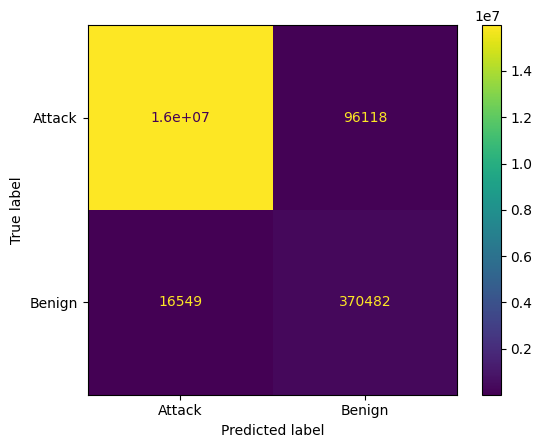

CNN
              precision    recall  f1-score   support

      Attack       1.00      0.99      1.00  16072228
      Benign       0.79      0.96      0.87    387031

    accuracy                           0.99  16459259
   macro avg       0.90      0.98      0.93  16459259
weighted avg       0.99      0.99      0.99  16459259

accuracy_score:  0.9931547951217002
recall_score:  0.8964843208939793
precision_score:  0.9756303865736761
f1_score:  0.9322503403741105


In [12]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import matplotlib.pyplot as plt
for k, v in d_preds.items():
    if isinstance(v, list):
        v = np.array(v)
    y_preds = np.argmax(v, axis=1)
    label_encoder.fit(original_labels)
    y_preds = label_encoder.inverse_transform(y_preds)
    from sklearn.metrics import ConfusionMatrixDisplay
    print(f"\nConfusion Matrix:\n")
    ConfusionMatrixDisplay.from_predictions(y_test, y_preds)
    plt.show()
    from sklearn.metrics import classification_report
    
    print(f"{DL_names[k]}")
    print(classification_report(y_test,y_preds))
    print('accuracy_score: ', accuracy_score(y_preds, y_test))
    print('recall_score: ', recall_score(y_preds, y_test, average='macro'))
    print('precision_score: ', precision_score(y_preds, y_test, average='macro'))
    print('f1_score: ', f1_score(y_preds, y_test, average='macro'))

In [13]:
from keras.models import model_from_json
import os

# Save model
def save_model(model, model_name):
    # Serialize model to JSON
    model_json = model.to_json()
    with open(model_name + ".json", "w") as json_file:
        json_file.write(model_json)

    # Serialize weights to HDF5
    model.save_weights(model_name + ".weights.h5")
modelCNN = build_CNN_model(input_shape=(len(X_columns), 1))
save_model(modelCNN, "/kaggle/working/CNN2classfinal")